
In this notebook supervised learning techniques are used to classify spectra for stars. Spectra are very detailed colors. Instead of 3 colors like in RGB they can have much more. In our case they are 3072 in the data. Like images they have numeric values. Here they are floats, thus the features are a vector 3072 floats.
Usually spectra are classfied by looking per eye on plots the feature value as function of the feature. Here we aim to replace that time consuming method by an automatic one. 

In [45]:
#basic libraries
import numpy as np

import pandas as pd
import scipy as sp

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


# xgboost is likely not used
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#logistic regression mainly used 
from sklearn.linear_model import LogisticRegression

#Keras Neural network likely not used 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

#Astrop.io is needed to read the files with the astronomical features. 
#not anymore because data is already converted 
#from astropy.io import fits

Below we load the feature and label data.

In [7]:
#directory of the data
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
#feature data
x=np.loadtxt(path+'feature_classification.txt')
print(f"shape of feature data is {np.shape(x)}")
print(f"There are {np.shape(x)[1]} examples with each {np.shape(x)[0]} features")
#includes besides main labels also other data
yplus=np.loadtxt(path+'label_classification.txt')
print(f"shape of label data is {np.shape(yplus)}")
#there are three labels values
print(f"number of 0 labels {np.count_nonzero(yplus[0,:]==0)}")
print(f"number of 1 labels {np.count_nonzero(yplus[0,:]==1)}")
print(f"number of 2 labels {np.count_nonzero(yplus[0,:]==2)}")

shape of feature data is (3072, 3773)
There are 3773 examples with each 3072 features
shape of label data is (5, 3773)
number of 0 labels 57
number of 1 labels 3661
number of 2 labels 55


There are three exclusive labels. 1 and 2 describe different recognisable classes. 0 is the label for all examples for which the class cannot be identified.

 We now look on the features to exclude some of them. For that we calculate basic statistic for the full data and for each class separately. 

In [ ]:
#separate the classes for calculating statistics
class0=x[:,np.where(yplus[0,:]==0)]
class1=x[:,np.where(yplus[0,:]==1)]
class2=x[:,np.where(yplus[0,:]==2)]
print(f"shape of class 0 features{np.shape(class0)}")
res=np.zeros((15,3072))
cg=np.shape(x)[1] #number  of examples
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg
    res[2,i]=1.92499995231628+i*0.000187174489838071  #wavelength in micron the physical meaning of the labels 
    res[3,i]=np.mean(x[i]) #statistic for all
    res[4,i]=np.median(x[i])    
    res[5,i]=np.std(x[i])  
    res[6,i]=np.mean(class0[i]) #statistic for class0
    res[7,i]=np.median(class0[i])  #  
    res[8,i]=np.std(class0[i])    #standard deviation
    res[9,i]=np.mean(class1[i]) #statistic for class1
    res[10,i]=np.median(class1[i])    
    res[11,i]=np.std(class1[i])
    res[12,i]=np.mean(class2[i]) #statistic of class2
    res[13,i]=np.median(class2[i])    
    res[14,i]=np.std(class2[i])  

We now plot the mean of all features. 

Text(0, 0.5, 'feature value')

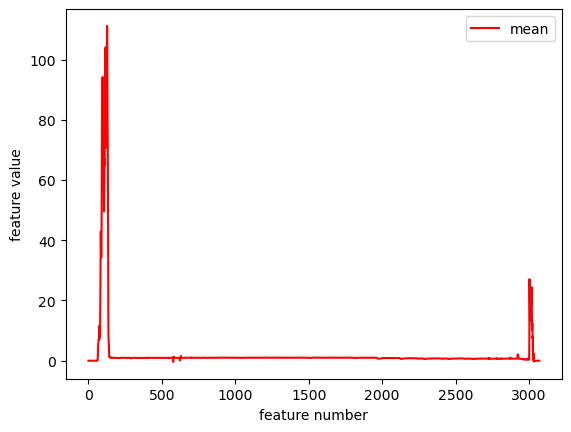

In [47]:
   
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.legend(loc="best")
#plt.xlim(1.95,2.48)
#plt.ylim(0.3,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

Some of most extreme values are much larger than most. We zoom into them. 

Text(0, 0.5, 'feature value')

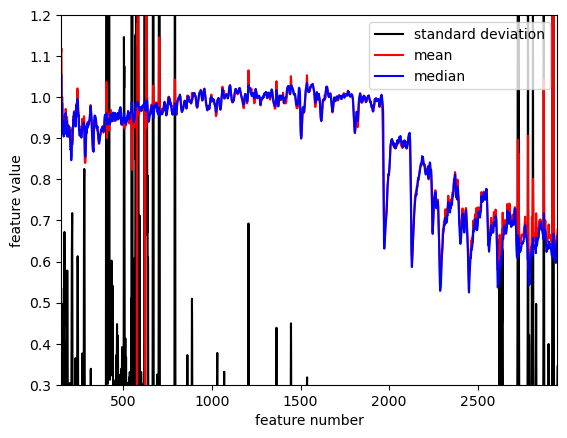

In [48]:
plt.plot(res[0],res[5],'-',color='black',label='standard deviation') 
plt.plot(res[0],res[3],'-',color='red',label='mean') 
plt.plot(res[0],res[4],'-',color='blue',label='median') 
plt.legend(loc="best")
plt.xlim(150,2950)
plt.ylim(0.3,1.2)
plt.xlabel("feature number")
plt.ylabel("feature value")

At some features smaller than about 800 and for features larger than about 2700 the standard deviation ('variation between different examples') is as large or larger than the typical value there.

To avoid these more difficult ranges we restrict the feature range by selecting. 

In [12]:
#lower and upper border
low=800
high=2700
#features selection
xsel=x[low:high]
#statistic selection
ressel=res[:,low:high] 
print(np.shape(ressel))
#add a new feature index which starts at 0 
resselb=np.zeros((16,1900))
resselb[0:15,:]=ressel
resselb[15,:]=np.arange(0,1900,1)
# some visulazation would be good best by type heatmap does not work too slow 
#sns.heatmap(xsel, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('features'),plt.xlabel('feature number'),plt.ylabel('example number');

(15, 1900)


We look now on the classes in the selected range. 

Text(0, 0.5, 'average')

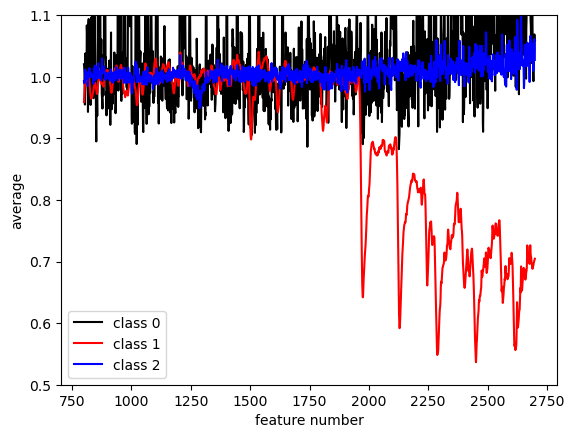

In [13]:
plt.plot(ressel[0],ressel[6],'-',color='black',label='class 0') 
plt.plot(ressel[0],ressel[9],'-',color='red',label='class 1') 
plt.plot(ressel[0],ressel[12],'-',color='blue',label='class 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

Text(0, 0.5, 'standard deviation')

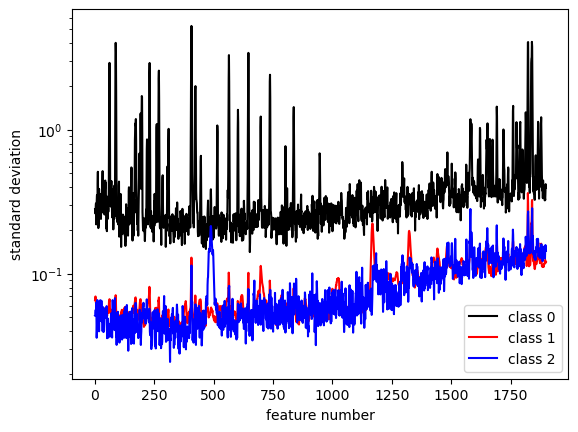

There are clear differences in the mean feature value between class 1 and class 2. It is less clear for class 0. 

We use a relative large test set is used because not many sources are in the rare classes 0 and 2.

In [51]:
xsel_train, xsel_test, y_train, y_test, yplus_train,yplus_test= train_test_split(np.transpose(xsel), yplus[0], yplus.T, test_size=0.3, random_state=42)
print(f"shape of training features {np.shape(xsel_train)}")
print(f"shape of training labels {np.shape(y_train)}")

shape of training features (2641, 1900)
shape of training labels (2641,)


We use logistic regression sinvce it is relative simple and it can be easier interpreted. 

In [52]:
#We fit it to the training data
lr1 = LogisticRegression('none',max_iter=200)
lr1.fit(xsel_train,y_train)

LogisticRegression(max_iter=200, penalty='none')

We are now making prediction for the test and training set. 

In [17]:
#Here probabilities are calculated for each class.
restr=lr1.predict_proba(xsel_train)  
#here is the most likely class is the prediction
restrc=lr1.predict(xsel_train)  
restec=lr1.predict(xsel_test)


We are now calculating the confusion matrix and display them. 

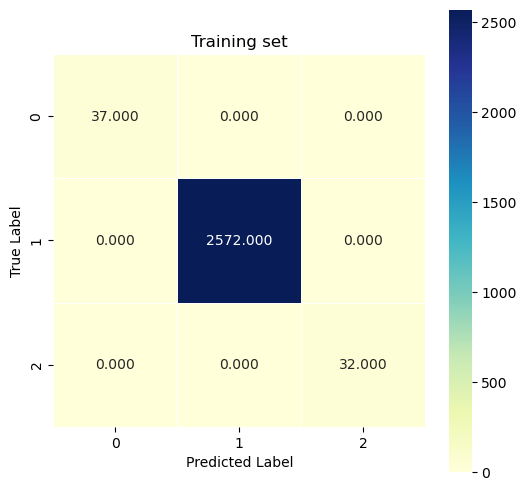

In [18]:
cm_nbtrain = confusion_matrix(y_train, restrc)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtrain, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Training set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visisble in the confusion matrix, the model predicts the labels perfectly for the training label. We are now looking on the test set, see below. 

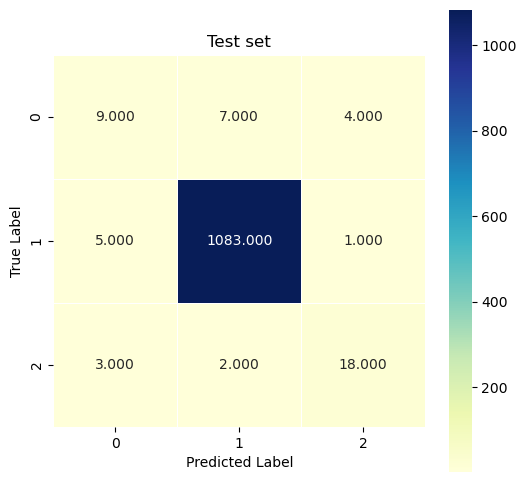

In [19]:
cm_nbtest = confusion_matrix(y_test, restec)
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

In it there are number of missclassified sources. That means that is overfitting, the 
algorithm separates the classes partly by using feature which are only by chance useful but not general. 

To be quantitaive in decding how good the model is we use the F1 measure of each class. We use class separatly because
as expected the rare classes seem more difficult. 

In [20]:
#gets f1 score for a specified  from confusing matrix 
def fmeas(conf_matrix,x):
    if np.sum(conf_matrix[:,x])==0:
        prec=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
    if np.sum(conf_matrix[x])==0:
        rec=0
    else:
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])

    if prec==0 and rec==0:
        f1=0
    else:
        prec=conf_matrix[x,x]/np.sum(conf_matrix[:,x])
        rec=conf_matrix[x,x]/np.sum(conf_matrix[x])
        f1=(2*prec*rec)/(prec+rec)
    return f1

In [21]:
print(f"F1 score (test, class 0) {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 1) {round(fmeas(cm_nbtest,1),3)}")
print(f"F1 score (test, class 2) {round(fmeas(cm_nbtest,2),3)}")

F1 score (test, class 0) 0.486
F1 score (test, class 1) 0.993
F1 score (test, class 2) 0.783


The F1 is worth for class 2 and even worse for class 0. That class 0 is most difficult is to be expected, because it is a left over class.

To reduce overfitting, we now add regularization. We explore a range of regularzations parameters.


In [22]:
#regularzaition in steps of factor 2
regs=np.zeros((7,16))
regs[0,0]=10
regs[0,1]=5
regs[0,2]=2.2
regs[0,3]=1
regs[0,4]=0.5
regs[0,5]=0.22
regs[0,6]=0.1
regs[0,7]=0.05
regs[0,8]=0.022
regs[0,9]=0.01
regs[0,10]=0.005
regs[0,11]=0.0022
regs[0,12]=0.001
regs[0,13]=0.0005
regs[0,14]=0.00022
regs[0,15]=0.0001
for i in range(np.shape(regs)[1]):
    print(f"regulurization {regs[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs[0,i])
    lr3.fit(xsel_train,y_train)
    restrc3=lr3.predict(xsel_train)  
    restec3=lr3.predict(xsel_test)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs[1,i]=fmeas(cm_nbtest3,0)
    regs[2,i]=fmeas(cm_nbtest3,2)
    regs[3,i]=np.mean(regs[1:3,i])
    regs[4,i]=fmeas(cm_nbtrain3,0)
    regs[5,i]=fmeas(cm_nbtrain3,2)
    regs[6,i]=np.mean(regs[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.519
F1 score (test, class 2) best regulurization 0.836


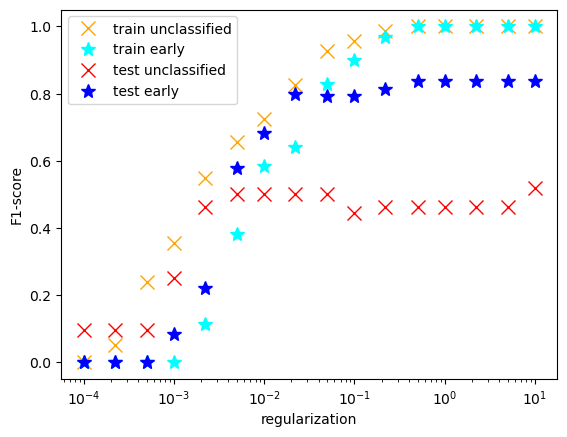

In [23]:
plt.plot(regs[0],regs[4],'x',color='orange',ms=10,label='train unclassified') 
plt.plot(regs[0],regs[5],'*',color='cyan',ms=10,label='train early') 
plt.plot(regs[0],regs[1],'x',color='red',ms=10,label='test unclassified') 
plt.plot(regs[0],regs[2],'*',color='blue',ms=10,label='test early') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")

Regularization improves only a little for test, the best F1 score a very similar to the F1 score with no regularization. 

Intrinsic noisy (random variation, best visible between neighboring features) clearly affects the data. It is a main reason for unclassified classifications. Logistic regression cannot recogize that from the features because of the random effects of noise and the independence of features in logistic regression. The measure of the instrinsic noisyness is the signal to onise. The signal to noise is calculated standard deviation between the features and the features smoothed with a Gaussian of a width of 1 pixel over the wavelength range between 2.08 and 2.29 were the features are normalized.
We use its inverse, the noise level here, to make it more important when the signal is low.
This feature is scaled on the a similar level as the other features, by scaling the mean in the training samples to one. 

Text(0, 0.5, 'standard deviation')

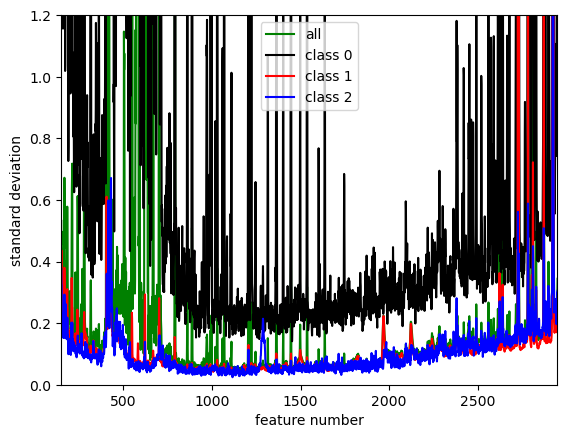

Text(0, 0.5, 'standard deviation')

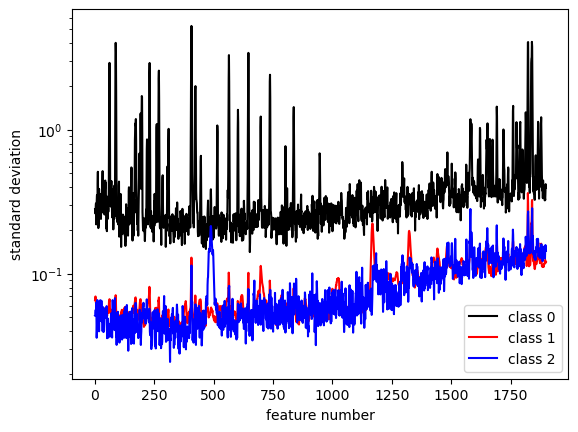

In [49]:
plt.plot(resselb[15],resselb[8],'-',color='black',label='class 0') 
plt.plot(resselb[15],resselb[11],'-',color='red',label='class 1') 
plt.plot(resselb[15],resselb[14],'-',color='blue',label='class 2') 
plt.legend(loc="best")
#plt.ylim(0,1.1)
plt.yscale("log")
plt.xlabel("feature number")
plt.ylabel("standard deviation")

In [24]:
#the noise lvel is feature is currently in the general labels at 7
print(f"s/n is {yplus[4]}")
#add noise to new feature vector
print(f"current feature shape of traing set is {np.shape(xsel_train)}")
#create new features
xsel_train2=np.zeros((np.shape(xsel_train)[0],np.shape(xsel_train)[1]+1))
xsel_test2=np.zeros((np.shape(xsel_test)[0],np.shape(xsel_test)[1]+1))
#copy old 
xsel_train2[:,0:np.shape(xsel_train)[1]]=xsel_train
xsel_test2[:,0:np.shape(xsel_test)[1]]=xsel_test
#add noise level as feature it
xsel_train2[:,np.shape(xsel_train)[1]]=1/yplus_train[:,4]/np.mean(1/yplus_train[:,4])
xsel_test2[:,np.shape(xsel_test)[1]]=1/yplus_test[:,4]/np.mean(1/yplus_train[:,4])
print(f"mean of noise feature is {np.mean(xsel_train2[:,np.shape(xsel_train)[1]])}")

s/n is [ 54.56041175  58.37582071  49.42498075 ...  51.15859649  93.74415085
 146.37331923]
current feature shape of traing set is (2641, 1900)
mean of noise feature is 1.0


We repeat now the regularized logistic regression but now with the noise level as additional feature.

In [25]:
#regularzaition in steps of factor 2
regs2=np.zeros((7,16))
regs2[0,0]=10
regs2[0,1]=5
regs2[0,2]=2.2
regs2[0,3]=1
regs2[0,4]=0.5
regs2[0,5]=0.22
regs2[0,6]=0.1
regs2[0,7]=0.05
regs2[0,8]=0.022
regs2[0,9]=0.01
regs2[0,10]=0.005
regs2[0,11]=0.0022
regs2[0,12]=0.001
regs2[0,13]=0.0005
regs2[0,14]=0.00022
regs2[0,15]=0.0001
for i in range(np.shape(regs2)[1]):
    print(f"regulurization {regs2[0,i]}")
    lr3 = LogisticRegression('l2',max_iter=1500,C=regs2[0,i])
    lr3.fit(xsel_train2,y_train)
    restrc3=lr3.predict(xsel_train2)  
    restec3=lr3.predict(xsel_test2)
    cm_nbtest3 = confusion_matrix(y_test, restec3)
    cm_nbtrain3 = confusion_matrix(y_train, restrc3)  
    regs2[1,i]=fmeas(cm_nbtest3,0)
    regs2[2,i]=fmeas(cm_nbtest3,2)
    regs2[3,i]=np.mean(regs2[1:3,i])
    regs2[4,i]=fmeas(cm_nbtrain3,0)
    regs2[5,i]=fmeas(cm_nbtrain3,2)
    regs2[6,i]=np.mean(regs2[4:6,i])  

regulurization 10.0
regulurization 5.0
regulurization 2.2
regulurization 1.0
regulurization 0.5
regulurization 0.22
regulurization 0.1
regulurization 0.05
regulurization 0.022
regulurization 0.01
regulurization 0.005
regulurization 0.0022
regulurization 0.001
regulurization 0.0005
regulurization 0.00022
regulurization 0.0001


F1 score (test, class 0) no regulurization 0.486
F1 score (test, class 2) no regulurization 0.783
F1 score (test, class 0) best regulurization 0.519
F1 score (test, class 2) best regulurization 0.836
F1 score (test, class 0) best regulurization with noise 0.788
F1 score (test, class 2) best regulurization with noise 0.92


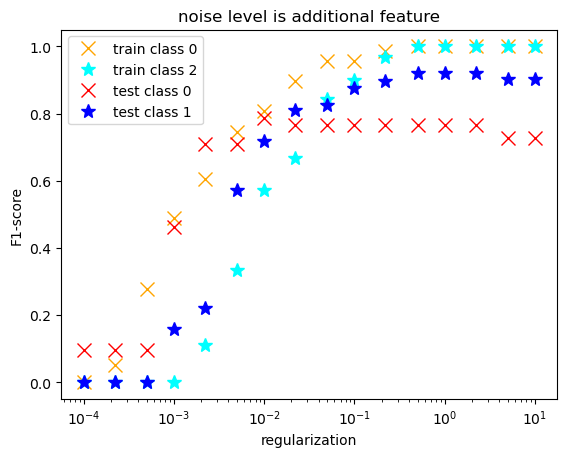

In [26]:
plt.plot(regs2[0],regs2[4],'x',color='orange',ms=10,label='train class 0') 
plt.plot(regs2[0],regs2[5],'*',color='cyan',ms=10,label='train class 2') 
plt.plot(regs2[0],regs2[1],'x',color='red',ms=10,label='test class 0') 
plt.plot(regs2[0],regs2[2],'*',color='blue',ms=10,label='test class 1') 
plt.legend(loc="best")
plt.xlabel("regularization")
plt.xscale("log")
plt.ylabel("F1-score")
plt.title("noise level is additional feature")
print(f"F1 score (test, class 0) no regulurization {round(fmeas(cm_nbtest,0),3)}")
print(f"F1 score (test, class 2) no regulurization {round(fmeas(cm_nbtest,2),3)}")
print(f"F1 score (test, class 0) best regulurization {round(max(regs[1]),3)}")
print(f"F1 score (test, class 2) best regulurization {round(max(regs[2]),3)}")
print(f"F1 score (test, class 0) best regulurization with noise {round(max(regs2[1]),3)}")
print(f"F1 score (test, class 2) best regulurization with noise {round(max(regs2[2]),3)}")

Adding the noise as additional parameter has clearly improved the classification performance. As before there is overfitting with large C since it performs better on the traing set than on the test set but the overfitting does not seem to impact the performance on the test sample much. The clasification of class 0 peaks for  C~0.01 while the earky clasfication improves until about 1 by a larger amount. That behaviour is to be expected, because in the absent of many common properties of class 0 less are needed to recognise it as well as possible in the rather small sample. 

We now look closer on the problems in classification. For that we run it again with  C of 1 and plot the confusion matrix.

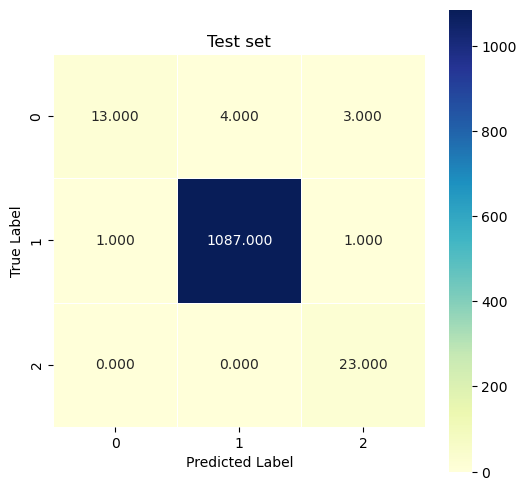

In [41]:
lr3 = LogisticRegression('l2',max_iter=1500,C=1)
lr3.fit(xsel_train2,y_train)
restrc3=lr3.predict(xsel_train2)  
restec3=lr3.predict(xsel_test2)
restrp3=lr3.predict_proba(xsel_train2)  
restep3=lr3.predict_proba(xsel_test2)
cm_nbtest4 = confusion_matrix(y_test, restec3)
cm_nbtrain4 = confusion_matrix(y_train, restrc3)  
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest4, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');

As visible in the confusion matrix the main problem is that class 0 cases are classfied as other classes. We now look on the missclasfied examples. 

(1, 4, 1900)


Text(0, 0.5, 'average')

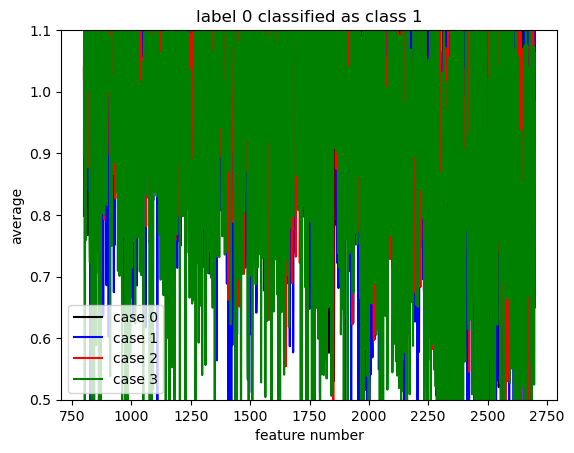

In [28]:
class0as1=xsel_test[np.where((y_test==0) & (restec3==1)),:]
class0as2=xsel_test[np.where((y_test==0) & (restec3==2)),:]
class1as0=xsel_test[np.where((y_test==1) & (restec3==0)),:]
class1as2=xsel_test[np.where((y_test==1) & (restec3==2)),:]
print(np.shape(class0as1))
plt.plot(ressel[0],class0as1[0,0,:],'-',color='black',label='case 0') 
plt.plot(ressel[0],class0as1[0,1,:],'-',color='blue',label='case 1') 
plt.plot(ressel[0],class0as1[0,2,:],'-',color='red',label='case 2') 
plt.plot(ressel[0],class0as1[0,3,:],'-',color='green',label='case 3') 
plt.title("label 0 classified as class 1")
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.xlabel("feature number")
plt.ylabel("average")

The feature data is very noisy, therfore we smooth the data for better visualization.

Text(0, 0.5, 'average')

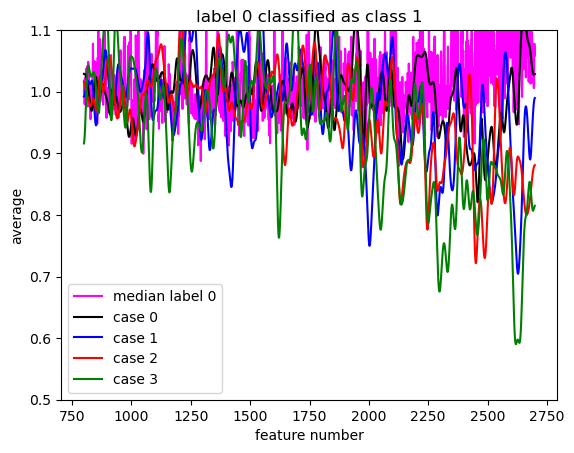

In [29]:
#add probailities in plot
plt.plot(ressel[0],ressel[7],'-',color='magenta',label='median label 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,0,:],8),'-',color='black',label='case 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,1,:],8),'-',color='blue',label='case 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,2,:],8),'-',color='red',label='case 2') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as1[0,3,:],8),'-',color='green',label='case 3') 
plt.legend(loc="best")
plt.ylim(0.5,1.1)
plt.title("label 0 classified as class 1")
plt.xlabel("feature number")
plt.ylabel("average")

Text(0, 0.5, 'average')

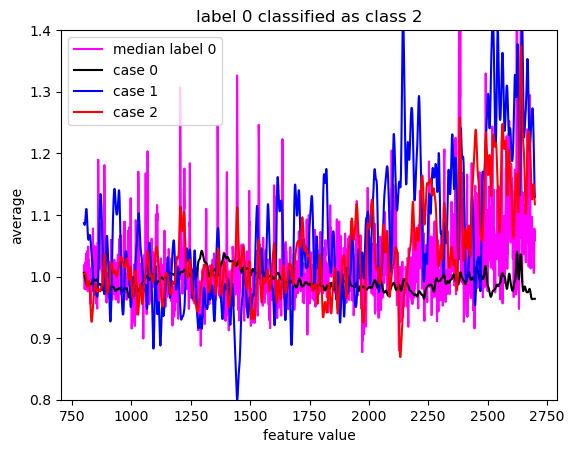

In [30]:
plt.plot(ressel[0],ressel[7],'-',color='magenta',label='median label 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,0,:],4),'-',color='black',label='case 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,1,:],4),'-',color='blue',label='case 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class0as2[0,2,:],4),'-',color='red',label='case 2') 
plt.legend(loc="best")
plt.ylim(0.8,1.4)
plt.title("label 0 classified as class 2")
plt.xlabel("feature value")
plt.ylabel("average")

Text(0, 0.5, 'feature value')

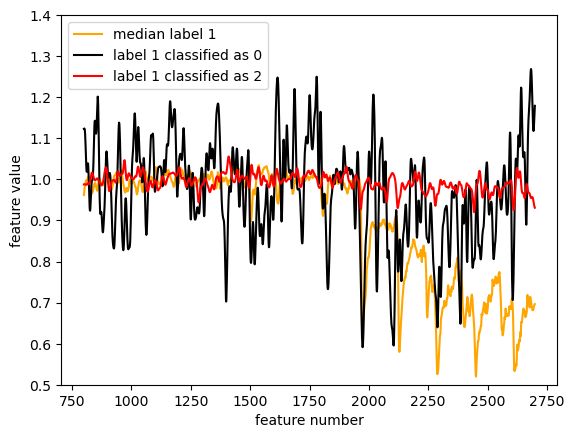

In [31]:
plt.plot(ressel[0],ressel[10],'-',color='orange',label='median label 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class1as0[0,0,:],4),'-',color='black',label='label 1 classified as 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(class1as2[0,0,:],4),'-',color='red',label='label 1 classified as 2') 
plt.legend(loc="best")
plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("feature value")

In most cases at can be understood why sources are understood as they are. The found solution looks mostly on the integerated signal and ignore narrow spike mostly. Usally the sources is also truely clases to the found classes, like that the class 1 idefied as class 2 above, has smaller spikes 

We now look at the probabilities. 

In [32]:
for i in range(np.shape(restec3)[0]):
    if restec3[i]!=y_test[i]:
        print(f"label {round(y_test[i])} has probabilities {np.round(restep3[i],5)}")

label 0 has probabilities [0.0098 0.1022 0.888 ]
label 1 has probabilities [0.01761 0.21782 0.76457]
label 0 has probabilities [0.08752 0.6745  0.23798]
label 0 has probabilities [0.15889 0.83148 0.00963]
label 1 has probabilities [0.84315 0.15485 0.002  ]
label 0 has probabilities [4.5100e-03 9.9498e-01 5.1000e-04]
label 0 has probabilities [0.05496 0.00264 0.9424 ]
label 0 has probabilities [1.3972e-01 8.5991e-01 3.7000e-04]
label 0 has probabilities [0.20504 0.08357 0.71139]


In most cases there is still a relevant probability for the assigned label of 10% or more. Only two cases have probabilities of less than 1%.

noise coefficients are [ 0.78530793 -0.27183081 -0.51347712]


Text(0, 0.5, 'coefficient')

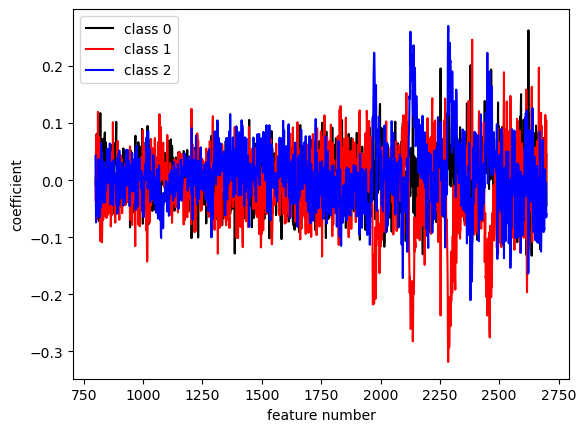

In [33]:
print(f"noise coefficients are {lr3.coef_[:,1900]}")
plt.plot(ressel[0],lr3.coef_[0,0:1900],'-',color='black',label='class 0') 
plt.plot(ressel[0],lr3.coef_[1,0:1900],'-',color='red',label='class 1') 
plt.plot(ressel[0],lr3.coef_[2,0:1900],'-',color='blue',label='class 2') 
#plt.plot(ressel[0],ressel[10],'-',color='orange',label='median label 1') 
plt.legend(loc="best")
#plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("coefficient")

Now smoothed for better visualization.

Text(0, 0.5, 'coefficient')

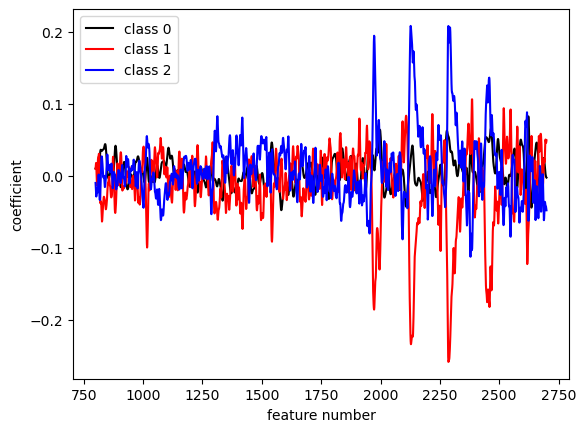

In [34]:
plt.plot(ressel[0],sp.ndimage.gaussian_filter(lr3.coef_[0,0:1900],4),'-',color='black',label='class 0') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(lr3.coef_[1,0:1900],2),'-',color='red',label='class 1') 
plt.plot(ressel[0],sp.ndimage.gaussian_filter(lr3.coef_[2,0:1900],2),'-',color='blue',label='class 2')  
plt.legend(loc="best")
#plt.ylim(0.5,1.4)
plt.xlabel("feature number")
plt.ylabel("coefficient")

The coefficents follow the strongest signal in the mean spectra of each class and of the inverse of the other classes.
In case of class 0 it is rather flat for the direct features, but the coefficient for noise is larger than anyother feature overall.  

In [35]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

print(np.min(classes_weights))
print(np.max(classes_weights))


0.34227579056505963
27.510416666666668


[[  15    1    4]
 [   6 1079    4]
 [   0    0   23]]
[[  13    4    3]
 [   1 1087    1]
 [   0    0   23]]


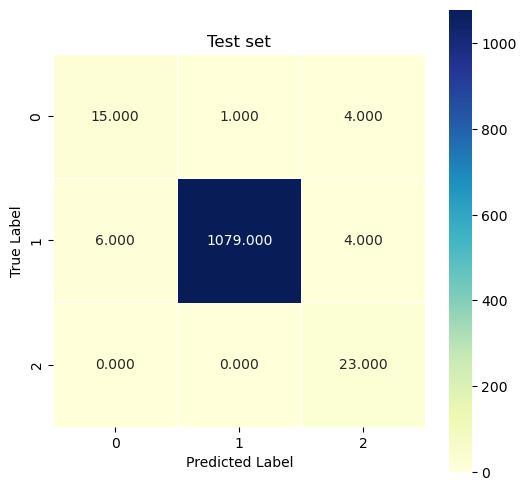

In [43]:
lr3 = LogisticRegression('l2',C=0.1,max_iter=1500,class_weight='balanced')
lr3.fit(xsel_train2,y_train)
restrc3=lr3.predict(xsel_train2)  
restec3=lr3.predict(xsel_test2)
restrp3=lr3.predict_proba(xsel_train2)  
restep3=lr3.predict_proba(xsel_test2)
cm_nbtest5 = confusion_matrix(y_test, restec3)
cm_nbtrain5 = confusion_matrix(y_train, restrc3)  
plt.figure(figsize = (6, 6));
sns.heatmap(cm_nbtest5, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"),plt.title('Test set'),plt.xlabel('Predicted Label'),plt.ylabel('True Label');
print(cm_nbtest5)
print(cm_nbtest4)
#weights do not improve
#depends also wjhat is wanted, is it F1, depends on purpose, final classification or to inspect 

In [53]:
#also do imbalanced learn? 

In [ ]:
#could here or elsewhere make the dataset less homogeneous, not
#noramlized, not atmosphere corrected, use of different spectra resolving powers
#that should make not logistic algorithm needed
#would also made the data set larger possible 